# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# magic word for producing visualizations in notebook
%matplotlib inline

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

In [ ]:
# import matplotlib.mlab as mlab
# import matplotlib.pyplot as plt

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
gen_demo_data = 'Udacity_AZDIAS_Subset.csv'
azdias = pd.read_csv(gen_demo_data, sep=';')

# Load in the feature summary file.
azdias_feat_summary = 'AZDIAS_Feature_Summary.csv'
feat_info = pd.read_csv(azdias_feat_summary, sep=';')

In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).

display(azdias.head(10))

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
5,3,1,2,2.0,3,1,5,2,2,5,...,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0
6,-1,2,2,5.0,1,5,1,5,4,3,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,4.0,6.0,3.0
7,-1,1,1,3.0,3,3,4,1,3,2,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,2.0,5.0,2.0
8,-1,3,1,3.0,4,4,2,4,2,2,...,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,4.0,3.0
9,-1,3,2,4.0,2,4,2,3,5,4,...,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,3.0,1.0


In [5]:
azdias.describe()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,891221.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,...,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,794005.000000,794005.000000,794005.00000
mean,-0.358435,2.777398,1.522098,3.632838,3.074528,2.821039,3.401106,3.033328,2.874167,3.075121,...,2.253330,2.801858,1.595426,0.699166,1.943913,3.612821,3.381087,3.167854,5.293002,3.07222
std,1.198724,1.068775,0.499512,1.595021,1.321055,1.464749,1.322134,1.529603,1.486731,1.353248,...,0.972008,0.920309,0.986736,0.727137,1.459654,0.973967,1.111598,1.002376,2.303739,1.36298
min,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.00000
25%,-1.000000,2.000000,1.000000,2.000000,2.000000,1.000000,3.000000,2.000000,2.000000,2.000000,...,1.000000,2.000000,1.000000,0.000000,1.000000,3.000000,3.000000,3.000000,4.000000,2.00000
50%,-1.000000,3.000000,2.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,2.000000,3.000000,2.000000,1.000000,1.000000,4.000000,3.000000,3.000000,5.000000,3.00000
75%,-1.000000,4.000000,2.000000,5.000000,4.000000,4.000000,5.000000,5.000000,4.000000,4.000000,...,3.000000,3.000000,2.000000,1.000000,3.000000,4.000000,4.000000,4.000000,7.000000,4.00000
max,3.000000,9.000000,2.000000,6.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,4.000000,4.000000,3.000000,2.000000,5.000000,5.000000,5.000000,9.000000,9.000000,9.00000


In [5]:
azdias.shape


(891221, 85)

In [6]:
display(feat_info)
feat_info.shape

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]
5,FINANZ_SPARER,person,ordinal,[-1]
6,FINANZ_VORSORGER,person,ordinal,[-1]
7,FINANZ_ANLEGER,person,ordinal,[-1]
8,FINANZ_UNAUFFAELLIGER,person,ordinal,[-1]
9,FINANZ_HAUSBAUER,person,ordinal,[-1]


(85, 4)

> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [7]:

azdias.count("columns")

0         43
1         84
2         84
3         83
4         85
5         85
6         84
7         84
8         84
9         85
10        84
11        43
12        78
13        76
14        43
15        76
16        83
17        43
18        84
19        84
20        74
21        84
22        84
23        77
24        43
25        83
26        65
27        84
28        84
29        84
          ..
891191    85
891192    84
891193    85
891194    85
891195    85
891196    85
891197    85
891198    84
891199    84
891200    84
891201    85
891202    85
891203    74
891204    85
891205    84
891206    84
891207    84
891208    84
891209    84
891210    85
891211    84
891212    84
891213    85
891214    84
891215    84
891216    82
891217    84
891218    83
891219    84
891220    84
Length: 891221, dtype: int64

In [7]:
display(azdias.head(10))

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
5,3,1,2,2.0,3,1,5,2,2,5,...,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0
6,-1,2,2,5.0,1,5,1,5,4,3,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,4.0,6.0,3.0
7,-1,1,1,3.0,3,3,4,1,3,2,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,2.0,5.0,2.0
8,-1,3,1,3.0,4,4,2,4,2,2,...,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,4.0,3.0
9,-1,3,2,4.0,2,4,2,3,5,4,...,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,3.0,1.0


In [17]:
# Identify missing or unknown data values and convert them to NaNs.

for row in feat_info.itertuples():
    attr = row.attribute
    pattern = row.missing_or_unknown[1:-1]
    values = pattern.split(',')
    parsed_vals = []    
    for v in values:
        neg_mult = 1
        if v.find('-') != -1:
            neg_mult = -1
        v = v.strip('-')
        if v.isdecimal():
            n = int(v) * neg_mult
#             print("attr {} will have {} converted to nan".format(attr, n))
            parsed_vals.append(n)
        else:
#             print("attr {} will have {} converted to nan".format(attr, v))
            parsed_vals.append(v)
#     print("{}\n".format(parsed_vals))
    azdias[attr] = azdias[attr].replace(parsed_vals, np.nan)    
    
print("replaced various formats of unknown data values into standard NaN")    

replaced various formats of unknown data values into standard NaN


In [18]:
azdias.shape

(891221, 85)

In [5]:
display(azdias.ORTSGR_KLS9.head(25))

0     NaN
1     5.0
2     5.0
3     3.0
4     6.0
5     3.0
6     6.0
7     5.0
8     4.0
9     3.0
10    6.0
11    NaN
12    6.0
13    6.0
14    NaN
15    8.0
16    2.0
17    NaN
18    4.0
19    6.0
20    4.0
21    7.0
22    5.0
23    6.0
24    NaN
Name: ORTSGR_KLS9, dtype: float64

In [6]:
# total rows in dataframe
len(azdias)

891221

In [5]:
# total non-nan rows per column
azdias.count()

AGER_TYP                 205378
ALTERSKATEGORIE_GROB     888340
ANREDE_KZ                891221
CJT_GESAMTTYP            886367
FINANZ_MINIMALIST        891221
FINANZ_SPARER            891221
FINANZ_VORSORGER         891221
FINANZ_ANLEGER           891221
FINANZ_UNAUFFAELLIGER    891221
FINANZ_HAUSBAUER         891221
FINANZTYP                891221
GEBURTSJAHR              498903
GFK_URLAUBERTYP          886367
GREEN_AVANTGARDE         891221
HEALTH_TYP               780025
LP_LEBENSPHASE_FEIN      793589
LP_LEBENSPHASE_GROB      796649
LP_FAMILIE_FEIN          813429
LP_FAMILIE_GROB          813429
LP_STATUS_FEIN           886367
LP_STATUS_GROB           886367
NATIONALITAET_KZ         782906
PRAEGENDE_JUGENDJAHRE    783057
RETOURTYP_BK_S           886367
SEMIO_SOZ                891221
SEMIO_FAM                891221
SEMIO_REL                891221
SEMIO_MAT                891221
SEMIO_VERT               891221
SEMIO_LUST               891221
                          ...  
OST_WEST

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [19]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.

# Alternate way of finding number of nan values per feature: nan_vals = azdias.isna().sum() or azdias.isnull().sum()

nan_vals = len(azdias) - azdias.count()

In [20]:
nan_vals.head

<bound method NDFrame.head of AGER_TYP                 685843
ALTERSKATEGORIE_GROB       2881
ANREDE_KZ                     0
CJT_GESAMTTYP              4854
FINANZ_MINIMALIST             0
FINANZ_SPARER                 0
FINANZ_VORSORGER              0
FINANZ_ANLEGER                0
FINANZ_UNAUFFAELLIGER         0
FINANZ_HAUSBAUER              0
FINANZTYP                     0
GEBURTSJAHR              392318
GFK_URLAUBERTYP            4854
GREEN_AVANTGARDE              0
HEALTH_TYP               111196
LP_LEBENSPHASE_FEIN       97632
LP_LEBENSPHASE_GROB       94572
LP_FAMILIE_FEIN           77792
LP_FAMILIE_GROB           77792
LP_STATUS_FEIN             4854
LP_STATUS_GROB             4854
NATIONALITAET_KZ         108315
PRAEGENDE_JUGENDJAHRE    108164
RETOURTYP_BK_S             4854
SEMIO_SOZ                     0
SEMIO_FAM                     0
SEMIO_REL                     0
SEMIO_MAT                     0
SEMIO_VERT                    0
SEMIO_LUST                    0
          

In [21]:
nan_vals_sorted = nan_vals.sort_values(ascending=False)

In [22]:
nan_vals_sorted.head(20)

TITEL_KZ          889061
AGER_TYP          685843
KK_KUNDENTYP      584612
KBA05_BAUMAX      476524
GEBURTSJAHR       392318
ALTER_HH          310267
REGIOTYP          158064
KKK               158064
W_KEIT_KIND_HH    147988
KBA05_ANTG4       133324
KBA05_GBZ         133324
MOBI_REGIO        133324
KBA05_ANTG1       133324
KBA05_ANTG2       133324
KBA05_ANTG3       133324
PLZ8_GBZ          116515
PLZ8_HHZ          116515
PLZ8_BAUMAX       116515
PLZ8_ANTG4        116515
PLZ8_ANTG1        116515
dtype: int64

In [24]:
vals = nan_vals_sorted.values
vals

array([889061, 685843, 584612, 476524, 392318, 310267, 158064, 158064,
       147988, 133324, 133324, 133324, 133324, 133324, 133324, 116515,
       116515, 116515, 116515, 116515, 116515, 116515, 111196, 111196,
       111196, 108315, 108164, 105800,  99611,  99352,  99352,  99352,
        97632,  97375,  97375,  97274,  97008,  94572,  93740,  93740,
        93740,  93155,  93148,  93148,  93148,  93148,  77792,  77792,
        73969,  73499,  73499,  73499,  73499,  18348,   4854,   4854,
         4854,   4854,   4854,   4854,   2881,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0])

(array([ 32.,  38.,   9.,   0.,   1.,   0.,   1.,   1.,   0.,   1.,   1.,
          0.,   0.,   1.]),
 array([      0.        ,   63504.35714286,  127008.71428571,
         190513.07142857,  254017.42857143,  317521.78571429,
         381026.14285714,  444530.5       ,  508034.85714286,
         571539.21428571,  635043.57142857,  698547.92857143,
         762052.28571429,  825556.64285714,  889061.        ]),
 <a list of 14 Patch objects>)

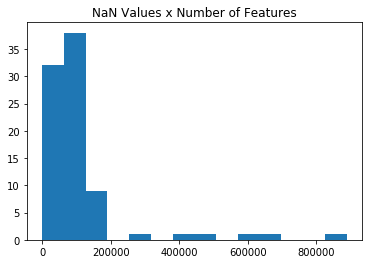

In [25]:
# visually look at the distribution of missing values

plt.title("NaN Values x Number of Features")
plt.hist(vals, bins = 14)


In [26]:
# flag columns with 20% or more NaN values

TWENTY_PERCENT_SAMPLE = 891221 * .2
elim_column_list = []
for index, value in nan_vals_sorted.items():
    if value > TWENTY_PERCENT_SAMPLE:
        print(index, value)       
        elim_column_list.append(index)

TITEL_KZ 889061
AGER_TYP 685843
KK_KUNDENTYP 584612
KBA05_BAUMAX 476524
GEBURTSJAHR 392318
ALTER_HH 310267


In [27]:
# Eliminate the 6 columns that were in the 80th percentile for most NaN values
# This also corresponds to the gap in the graph between most of the data and
# those few features with very high proportion of NaN values

elim_column_list
len(elim_column_list)


6

In [28]:
azdias.shape

(891221, 85)

In [10]:
TWENTY_PERCENT_SAMPLE

178244.2

In [58]:
# Investigate patterns in the amount of missing data in each column.

NUM_SAMPLES = 891221

for index, value in nan_vals_sorted.items():
    percent_missing = round(value * 100 / NUM_SAMPLES, 2)
    print ("{} has {}% missing values".format(index, percent_missing))
    

TITEL_KZ has 99.76% missing values
AGER_TYP has 76.96% missing values
KK_KUNDENTYP has 65.6% missing values
KBA05_BAUMAX has 53.47% missing values
GEBURTSJAHR has 44.02% missing values
ALTER_HH has 34.81% missing values
REGIOTYP has 17.74% missing values
KKK has 17.74% missing values
W_KEIT_KIND_HH has 16.61% missing values
KBA05_ANTG4 has 14.96% missing values
KBA05_GBZ has 14.96% missing values
MOBI_REGIO has 14.96% missing values
KBA05_ANTG1 has 14.96% missing values
KBA05_ANTG2 has 14.96% missing values
KBA05_ANTG3 has 14.96% missing values
PLZ8_GBZ has 13.07% missing values
PLZ8_HHZ has 13.07% missing values
PLZ8_BAUMAX has 13.07% missing values
PLZ8_ANTG4 has 13.07% missing values
PLZ8_ANTG1 has 13.07% missing values
PLZ8_ANTG3 has 13.07% missing values
PLZ8_ANTG2 has 13.07% missing values
SHOPPER_TYP has 12.48% missing values
VERS_TYP has 12.48% missing values
HEALTH_TYP has 12.48% missing values
NATIONALITAET_KZ has 12.15% missing values
PRAEGENDE_JUGENDJAHRE has 12.14% missing

In [29]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)

az2 = azdias.drop(columns=elim_column_list)

In [30]:
az2.shape

(891221, 79)

In [16]:
az2.head(20)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2.0,1,2.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,2,5.0,1,5,2,5,4,5,1,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3.0,2,3.0,1,4,1,2,3,5,1,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,4.0,2,2.0,4,2,5,2,1,2,6,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,3.0,1,5.0,4,3,4,1,3,2,5,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
5,1.0,2,2.0,3,1,5,2,2,5,2,...,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0
6,2.0,2,5.0,1,5,1,5,4,3,4,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,4.0,6.0,3.0
7,1.0,1,3.0,3,3,4,1,3,2,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,2.0,5.0,2.0
8,3.0,1,3.0,4,4,2,4,2,2,6,...,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,4.0,3.0
9,3.0,2,4.0,2,4,2,3,5,4,1,...,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,3.0,1.0


In [60]:
az2.shape

(891221, 79)

(Double click this cell and replace this text with your own text, reporting your observations regarding the amount of missing data in each column. Are there any patterns in missing values? Which columns were removed from the dataset?)

#### Discussion 1.1.2: Assess Missing Data in Each Column

*From the histogram, which plots the number of missing values on the x-axis and the number of features
with those missing values on the y-axis, we can see that the majority of the data falls into the clump
on the left side of the graph. More specifically, 32 + 38 + 9 features are in this clump, whereas 6
features fall to the right of the clump with significantly more missing values.*

*Using the histogram, we can use 20,000 missing values as the cutoff criteria. Alternatively, if we want to 
use 20% missing values as a guideline, then our threshold is 178,244 missing values. Percentage-wise (looking
at percent missing values per column as calculated in one of the cells above), we see a jump from 17.74% missing values to 34.81% and going
up to as high as nearly 100% missing values. Using any of these metrics--the histogram showing the outliers
off to the right, numerically or percentage-wise--suggests that we eliminate the same 6 features. Further,
since there are 85 features to begin with, we still have 79 features in the model after dropping these
columns.*





#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [ ]:
# use this if the nan_values column was already created before and needs to be re-created
# az2.drop(columns=['nan_values'], inplace=True)

In [31]:
# How much data is missing in each row of the dataset?

num_columns = len(az2.columns)
# print(num_columns)

# nan_vals_rows = num_columns - az2.count(axis=1)
# num_columns

In [32]:
# Count the number of non-NaN values per row and create a new column with number of NaN values
az2['nan_values'] = az2.apply(lambda x: num_columns - x.count(), axis=1)

In [33]:
az2.shape

(891221, 80)

In [63]:
# spot-check the newly created nan_values column
az2.nan_values.head(20)

0     43
1      0
2      0
3      7
4      0
5      0
6      0
7      0
8      0
9      0
10     0
11    47
12     6
13     8
14    47
15     8
16     6
17    47
18     3
19     0
Name: nan_values, dtype: int64

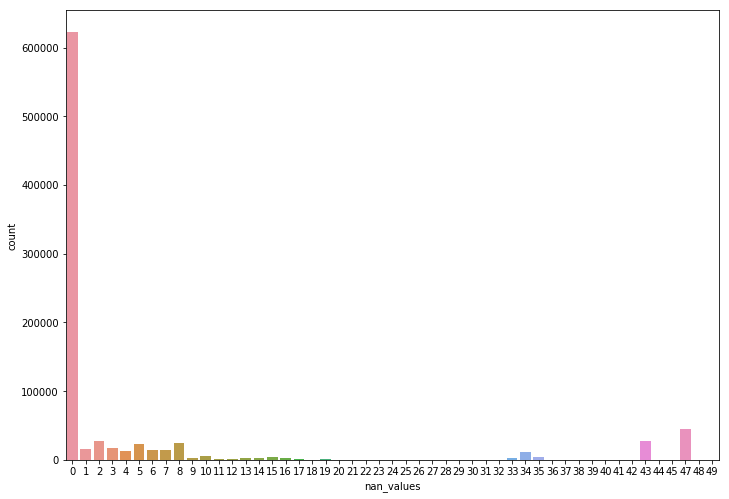

In [64]:
# Graph the distribution of NaN values across the dataset

ax = plt.subplots(figsize=(11.7, 8.27))
ax = sns.countplot(x="nan_values", data=az2)

In [61]:
# CUTOFF = 2

# az2_chunk1 = az2[az2['nan_values'] < CUTOFF]
# az2_chunk2 = az2[az2['nan_values'] >= CUTOFF]

In [34]:
# Divide dataset
# Most rows have 0-10 NaN values and a few have as many as 19. Then there is a huge
# gap before we see some rows with 33 and more NaN values. 

# Create dataframes with nan_values below and above (or equal to) the threshold

THRESHOLD = 20

az2_below_thresh = az2[az2['nan_values'] < THRESHOLD]
az2_above_thresh = az2[az2['nan_values'] >= THRESHOLD]

In [17]:
az2_below_thresh.head(12)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,nan_values
1,1.0,2,5.0,1,5,2,5,4,5,1,...,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0,0
2,3.0,2,3.0,1,4,1,2,3,5,1,...,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0,0
3,4.0,2,2.0,4,2,5,2,1,2,6,...,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0,7
4,3.0,1,5.0,4,3,4,1,3,2,5,...,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0,0
5,1.0,2,2.0,3,1,5,2,2,5,2,...,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0,0
6,2.0,2,5.0,1,5,1,5,4,3,4,...,3.0,1.0,0.0,1.0,5.0,5.0,4.0,6.0,3.0,0
7,1.0,1,3.0,3,3,4,1,3,2,5,...,3.0,1.0,0.0,1.0,4.0,4.0,2.0,5.0,2.0,0
8,3.0,1,3.0,4,4,2,4,2,2,6,...,3.0,2.0,1.0,1.0,3.0,3.0,2.0,4.0,3.0,0
9,3.0,2,4.0,2,4,2,3,5,4,1,...,3.0,2.0,1.0,1.0,3.0,3.0,2.0,3.0,1.0,0
10,3.0,2,1.0,2,2,5,3,1,5,6,...,4.0,2.0,0.0,2.0,3.0,3.0,4.0,6.0,5.0,0


In [35]:
az2_below_thresh.shape

(797077, 80)

In [19]:
# spot-check
az2_below_thresh.nan_values.head(20)

1      0
2      0
3      7
4      0
5      0
6      0
7      0
8      0
9      0
10     0
12     6
13     8
15     8
16     6
18     3
19     0
20    10
21     0
22     0
23     8
Name: nan_values, dtype: int64

In [20]:
# spot-check
az2_above_thresh.nan_values.head(20)

0     43
11    47
14    47
17    47
24    47
30    34
35    43
46    40
48    47
53    43
54    47
61    43
62    43
69    47
75    47
76    43
81    45
83    43
90    34
97    47
Name: nan_values, dtype: int64

In [55]:
az2_above_thresh.FINANZTYP

0         4
11        4
14        4
17        4
24        4
26        3
30        3
35        4
46        1
48        4
53        4
54        4
61        4
62        4
69        4
75        4
76        4
81        4
83        4
90        1
97        4
99        4
103       4
106       4
108       4
109       4
112       4
133       4
137       4
138       3
         ..
891049    4
891055    3
891061    4
891062    1
891063    4
891064    4
891069    2
891072    4
891074    1
891092    4
891095    4
891100    2
891117    5
891119    1
891120    1
891130    3
891137    2
891140    2
891154    5
891159    4
891164    4
891169    3
891170    3
891171    3
891172    1
891173    5
891175    4
891185    4
891187    4
891203    5
Name: FINANZTYP, Length: 111068, dtype: int64

In [50]:
az2_below_thresh.FINANZTYP

1         1
2         1
3         6
4         5
5         2
6         4
7         5
8         6
9         1
10        6
12        3
13        1
15        2
16        3
18        1
19        5
20        3
21        3
22        1
23        6
25        4
26        3
27        5
28        3
29        6
31        1
32        3
33        5
34        2
36        6
         ..
891191    2
891192    1
891193    5
891194    3
891195    2
891196    1
891197    5
891198    1
891199    1
891200    1
891201    6
891202    1
891203    5
891204    6
891205    2
891206    4
891207    2
891208    6
891209    1
891210    6
891211    2
891212    5
891213    6
891214    1
891215    1
891216    1
891217    6
891218    1
891219    1
891220    6
Name: FINANZTYP, Length: 797077, dtype: int64

In [66]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

def compare_distributions(feature, dset1, dset2):    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    graph_title = f"Compare distributions of Feature {feature}"
    fig.suptitle(graph_title, fontsize=16, verticalalignment='baseline')
    ax1.set_title("Below Threshold")
    ax2.set_title("Above Threshold")
    sns.countplot(x=feature, data=dset1, ax=ax1)
    sns.countplot(x=feature, data=dset2, ax=ax2)    

*from columns analysis above*

```
HH_EINKOMMEN_SCORE has 2.06% missing values
CJT_GESAMTTYP has 0.54% missing values
RETOURTYP_BK_S has 0.54% missing values
ONLINE_AFFINITAET has 0.54% missing values
LP_STATUS_FEIN has 0.54% missing values
LP_STATUS_GROB has 0.54% missing values
GFK_URLAUBERTYP has 0.54% missing values
ALTERSKATEGORIE_GROB has 0.32% missing values
FINANZTYP has 0.0% missing values
GREEN_AVANTGARDE has 0.0% missing values
FINANZ_HAUSBAUER has 0.0% missing values
FINANZ_UNAUFFAELLIGER has 0.0% missing values
FINANZ_ANLEGER has 0.0% missing values
FINANZ_SPARER has 0.0% missing values
FINANZ_MINIMALIST has 0.0% missing values
ANREDE_KZ has 0.0% missing values
FINANZ_VORSORGER has 0.0% missing values
SEMIO_FAM has 0.0% missing values
SEMIO_SOZ has 0.0% missing values
SEMIO_REL has 0.0% missing values
SEMIO_MAT has 0.0% missing values
SEMIO_VERT has 0.0% missing values
SEMIO_LUST has 0.0% missing values
SEMIO_ERL has 0.0% missing values
SEMIO_KULT has 0.0% missing values
SEMIO_RAT has 0.0% missing values
SEMIO_KRIT has 0.0% missing values
SEMIO_DOM has 0.0% missing values
SEMIO_KAEM has 0.0% missing values
SEMIO_PFLICHT has 0.0% missing values
SEMIO_TRADV has 0.0% missing values
ZABEOTYP has 0.0% missing values
```

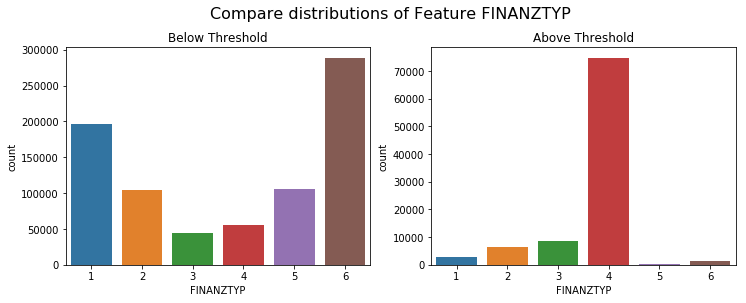

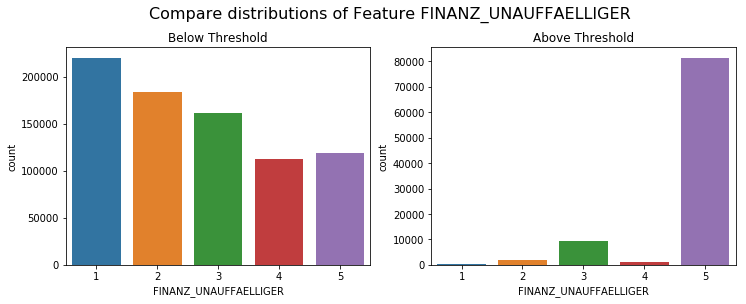

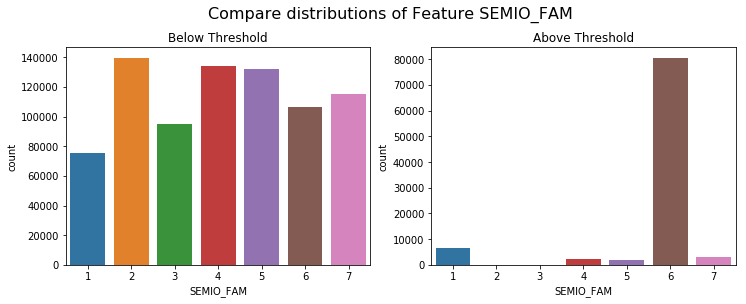

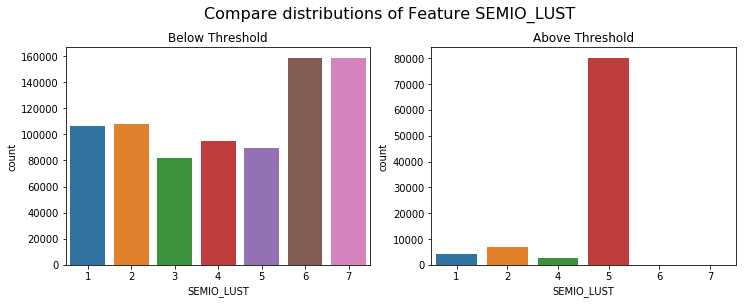

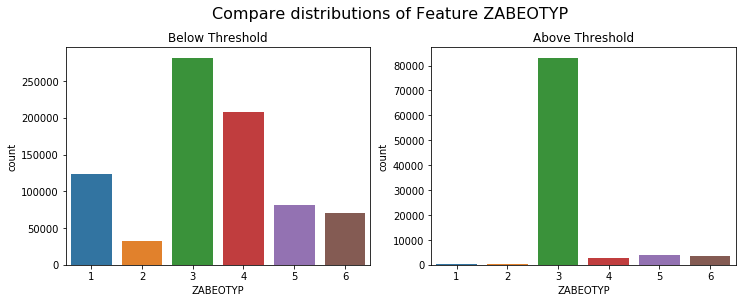

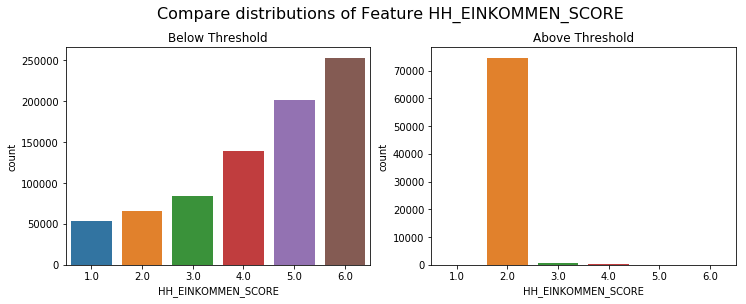

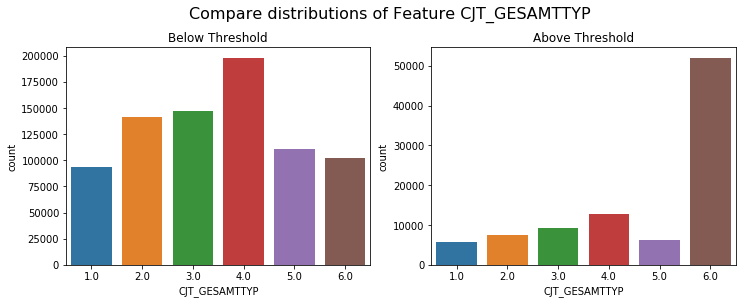

In [68]:
# compare_feats = ['PLZ8_ANTG1', 'PLZ8_ANTG2', 'PLZ8_BAUMAX', 'ARBEIT', 'ORTSGR_KLS9', 'RELAT_AB']
compare_feats = ['FINANZTYP', 'FINANZ_UNAUFFAELLIGER', 'SEMIO_FAM', 'SEMIO_LUST', 'ZABEOTYP', 'HH_EINKOMMEN_SCORE', 'CJT_GESAMTTYP']

for f in compare_feats:
    compare_distributions(f, az2_below_thresh, az2_above_thresh)

#### Discussion 1.1.3: Assess Missing Data in Each Row

(Double-click this cell and replace this text with your own text, reporting your observations regarding missing data in rows. Are the data with lots of missing values are qualitatively different from data with few or no missing values?)

The data with lots of missing values are in general qualitatively different from the data with few or no
missing values. Of the features tested, the distributions are not similar in shape. The graphs above display the
cutoff point at 20 missing values, but 11 was also tested. Only when the threshold is as low as 2,
which is well within the bulk of the data distribution with few missing values, do the distributions
look similar. This may indicate that the rows above the threshold are truly outliers.

In [ ]:
# going forward, use az2_below_thresh



### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [36]:
# How many features are there of each data type?

cat_features = []
mixed_features = []
for row in feat_info.itertuples():
    data_type = row.type
    if data_type == 'categorical':
        cat_features.append(row.attribute)
    elif data_type == 'mixed':
        mixed_features.append(row.attribute)

  
print(f"There are {len(cat_features)} features of type categorical")
print(f"There are {len(mixed_features)} features of type mixed")

There are 21 features of type categorical
There are 7 features of type mixed


#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [70]:
cat_features

['AGER_TYP',
 'ANREDE_KZ',
 'CJT_GESAMTTYP',
 'FINANZTYP',
 'GFK_URLAUBERTYP',
 'GREEN_AVANTGARDE',
 'LP_FAMILIE_FEIN',
 'LP_FAMILIE_GROB',
 'LP_STATUS_FEIN',
 'LP_STATUS_GROB',
 'NATIONALITAET_KZ',
 'SHOPPER_TYP',
 'SOHO_KZ',
 'TITEL_KZ',
 'VERS_TYP',
 'ZABEOTYP',
 'KK_KUNDENTYP',
 'GEBAEUDETYP',
 'OST_WEST_KZ',
 'CAMEO_DEUG_2015',
 'CAMEO_DEU_2015']

In [37]:
binary_category = []
multi_category = []
for c in cat_features:
    if c in az2_below_thresh:
        if az2_below_thresh[c].nunique() == 2:
            print(f"{c} is a binary category")
            binary_category.append(c)
        else:
            multi_category.append(c)

ANREDE_KZ is a binary category
GREEN_AVANTGARDE is a binary category
SOHO_KZ is a binary category
VERS_TYP is a binary category
OST_WEST_KZ is a binary category


In [72]:
binary_category

['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'VERS_TYP', 'OST_WEST_KZ']

In [73]:
multi_category

['CJT_GESAMTTYP',
 'FINANZTYP',
 'GFK_URLAUBERTYP',
 'LP_FAMILIE_FEIN',
 'LP_FAMILIE_GROB',
 'LP_STATUS_FEIN',
 'LP_STATUS_GROB',
 'NATIONALITAET_KZ',
 'SHOPPER_TYP',
 'ZABEOTYP',
 'GEBAEUDETYP',
 'CAMEO_DEUG_2015',
 'CAMEO_DEU_2015']

In [74]:
def show_distribution(feature, dset1):    
    fig, ax1 = plt.subplots(1, figsize=(12, 4))

    graph_title = f"Feature {feature}"
    fig.suptitle(graph_title, fontsize=16, verticalalignment='baseline')
    ax1.set_title("Below Threshold")
    sns.countplot(x=feature, data=dset1, ax=ax1)
   

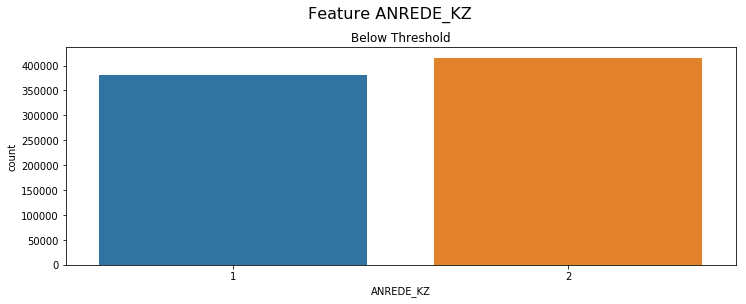

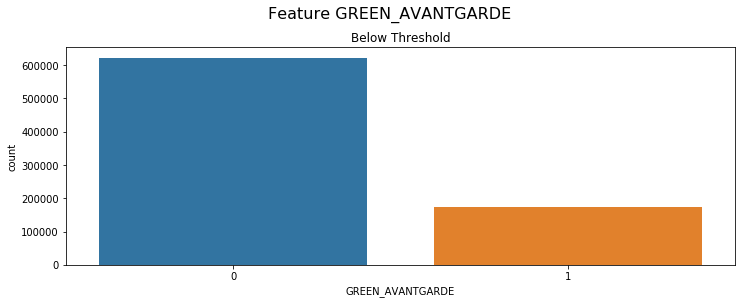

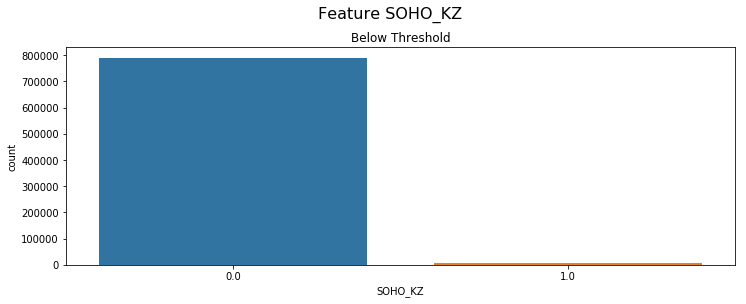

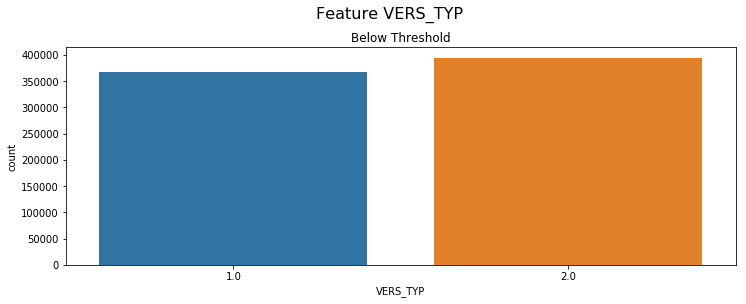

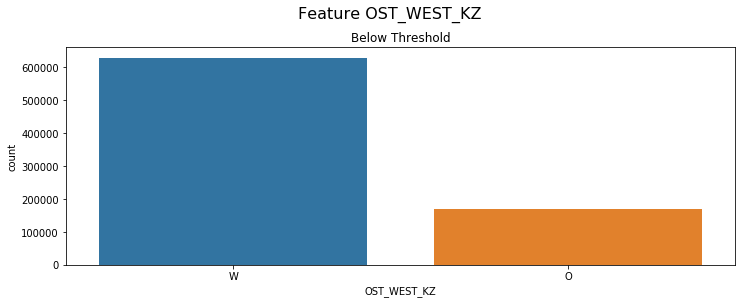

In [75]:
for f in binary_category:
    if f in az2_below_thresh:
        show_distribution(f, az2_below_thresh)

In [24]:
# Re-encode categorical variable(s) to be kept in the analysis.
# for Feature OST_WEST_KZ, replace the W with a 1 and the O with 2

# az2_below_thresh['OST_WEST_KZ'] = [ 1 if c == 'W' else 0 for c in ost_west ]
az2_below_thresh.loc[(az2_below_thresh.OST_WEST_KZ == 'W'),'OST_WEST_KZ']= 1.0
az2_below_thresh.loc[(az2_below_thresh.OST_WEST_KZ == 'O'),'OST_WEST_KZ']= 2.0


/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


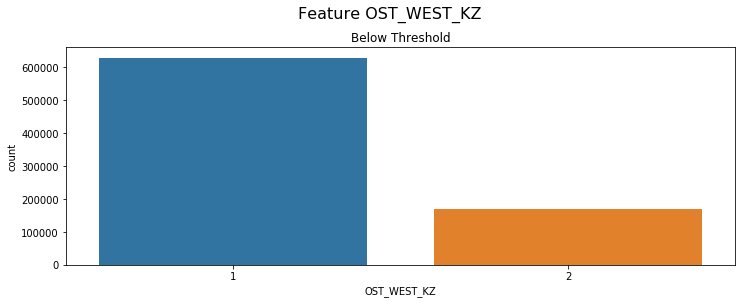

In [25]:
show_distribution('OST_WEST_KZ', az2_below_thresh)

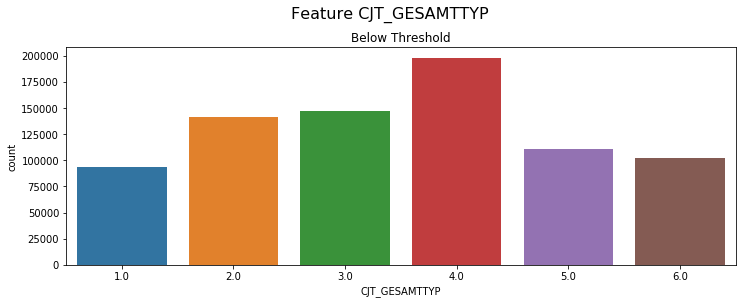

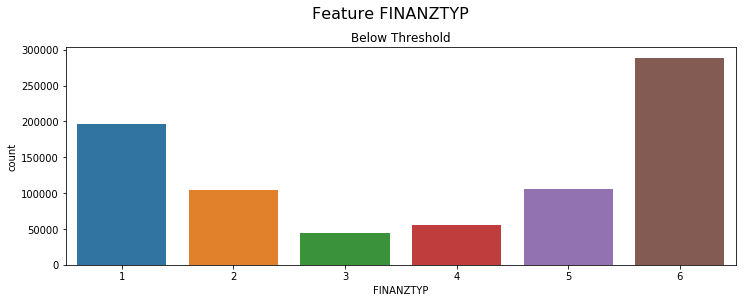

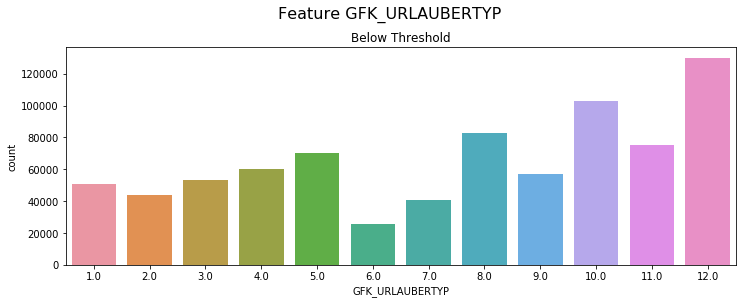

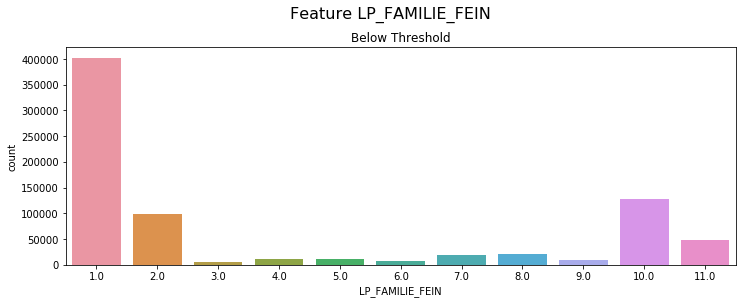

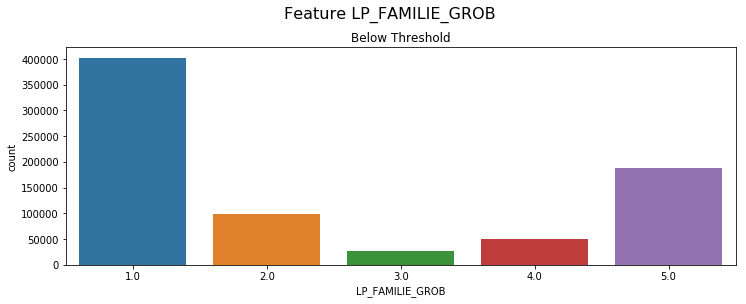

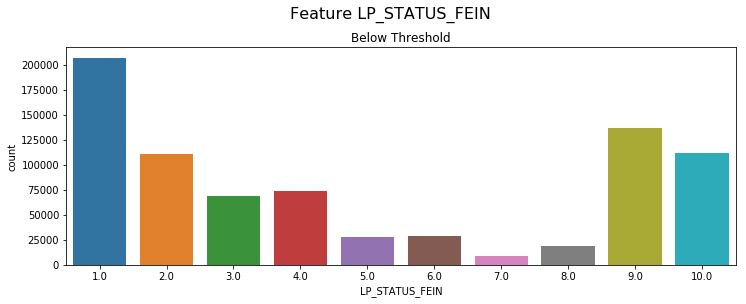

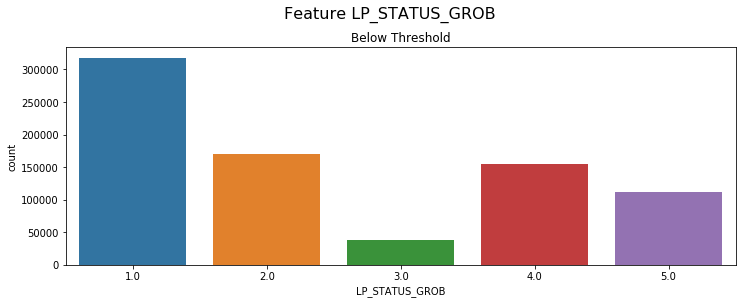

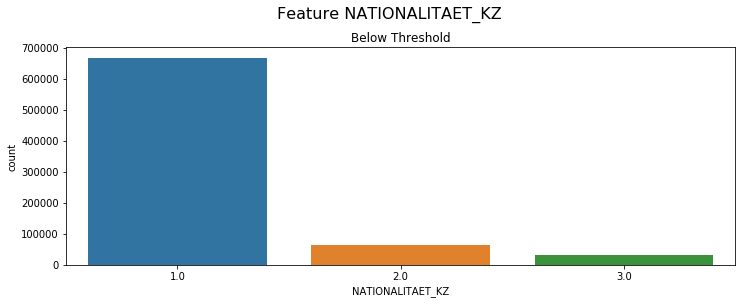

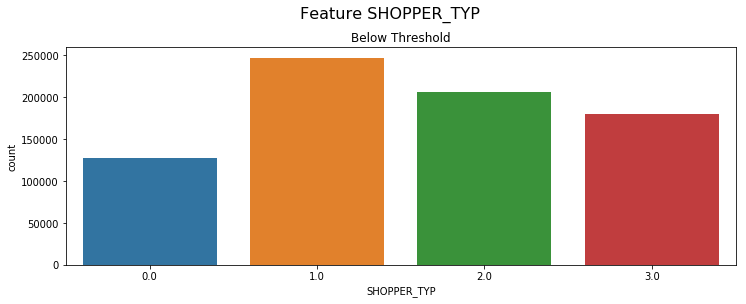

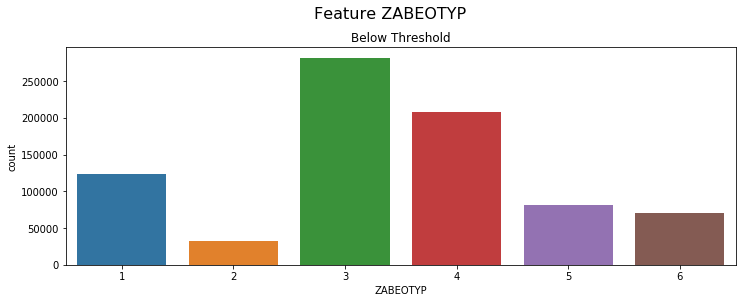

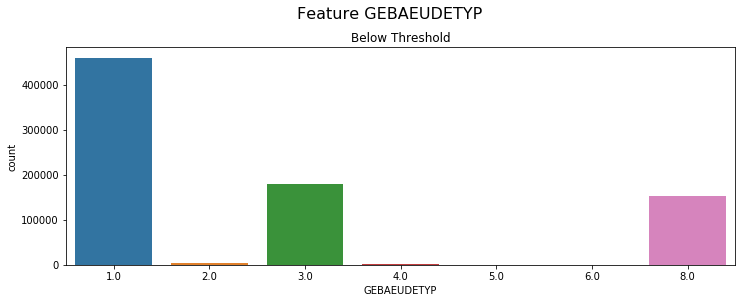

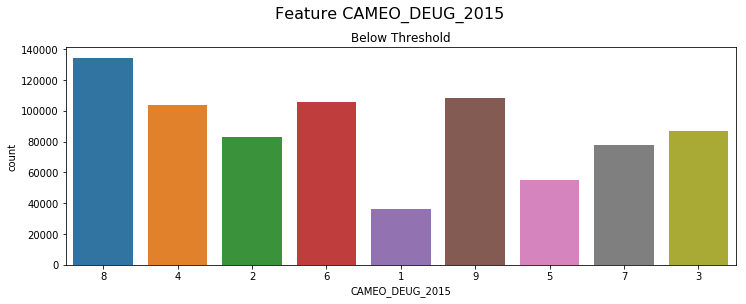

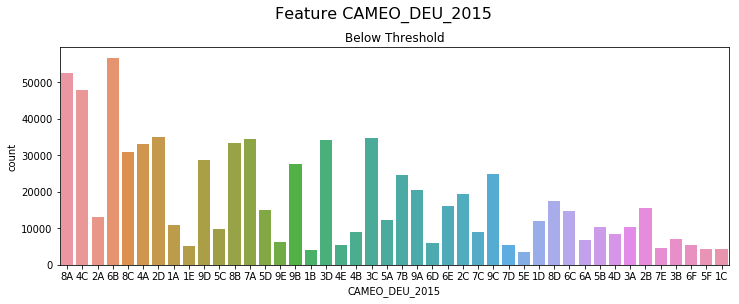

In [26]:
for f in multi_category:
    if f in az2_below_thresh:
        show_distribution(f, az2_below_thresh)

In [31]:
multi_category


['CJT_GESAMTTYP',
 'FINANZTYP',
 'GFK_URLAUBERTYP',
 'LP_FAMILIE_FEIN',
 'LP_FAMILIE_GROB',
 'LP_STATUS_FEIN',
 'LP_STATUS_GROB',
 'NATIONALITAET_KZ',
 'SHOPPER_TYP',
 'ZABEOTYP',
 'GEBAEUDETYP',
 'CAMEO_DEUG_2015',
 'CAMEO_DEU_2015']

In [38]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

feats_to_delete = []
for f in multi_category:
    if f != 'NATIONALITAET_KZ':
        feats_to_delete.append(f)
    

In [27]:
print(len(feats_to_delete))
print(len(multi_category))

12
13


In [28]:
az2_below_thresh.shape

(797077, 80)

In [39]:
# drop multi-category features that don't fit my criteria for one hot encoding

az2_subset_clean = az2_below_thresh.drop(columns=feats_to_delete)

In [40]:
az2_subset_clean.shape

(797077, 68)

In [43]:
az2_subset_clean.head(10)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,nan_values
1,1.0,2,1,5,2,5,4,5,0,3.0,...,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0,0
2,3.0,2,1,4,1,2,3,5,1,3.0,...,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0,0
3,4.0,2,4,2,5,2,1,2,0,2.0,...,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0,7
4,3.0,1,4,3,4,1,3,2,0,3.0,...,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0,0
5,1.0,2,3,1,5,2,2,5,0,3.0,...,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0,0
6,2.0,2,1,5,1,5,4,3,0,2.0,...,3.0,1.0,0.0,1.0,5.0,5.0,4.0,6.0,3.0,0
7,1.0,1,3,3,4,1,3,2,0,1.0,...,3.0,1.0,0.0,1.0,4.0,4.0,2.0,5.0,2.0,0
8,3.0,1,4,4,2,4,2,2,1,3.0,...,3.0,2.0,1.0,1.0,3.0,3.0,2.0,4.0,3.0,0
9,3.0,2,2,4,2,3,5,4,1,2.0,...,3.0,2.0,1.0,1.0,3.0,3.0,2.0,3.0,1.0,0
10,3.0,2,2,2,5,3,1,5,0,2.0,...,4.0,2.0,0.0,2.0,3.0,3.0,4.0,6.0,5.0,0


In [41]:
# one hot encode OST_WEST_KZ and NATIONALITAET_KZ

y = pd.get_dummies(az2_subset_clean.OST_WEST_KZ, prefix='OST_WEST_KZ')

In [42]:
y2 = pd.get_dummies(az2_subset_clean.NATIONALITAET_KZ, prefix='NATIONALITAET_KZ')

In [33]:
y.columns

Index(['OST_WEST_KZ_1', 'OST_WEST_KZ_2'], dtype='object')

In [34]:
y2.columns

Index(['NATIONALITAET_KZ_1.0', 'NATIONALITAET_KZ_2.0', 'NATIONALITAET_KZ_3.0'], dtype='object')

In [70]:
y2.head(5)

,NATIONALITAET_KZ_1.0,NATIONALITAET_KZ_2.0,NATIONALITAET_KZ_3.0
1,1,0,0
2,1,0,0
3,1,0,0
4,1,0,0
5,1,0,0


In [43]:
df = pd.concat([az2_subset_clean, y], axis=1)

In [44]:
df = pd.concat([df, y2], axis=1)

In [45]:
df.shape

(797077, 73)

In [46]:
# drop the original columns and keep the one hot encoded ones

cols = ['OST_WEST_KZ', 'NATIONALITAET_KZ']
df.drop(columns=cols, inplace=True)


In [47]:
df.shape

(797077, 71)

In [39]:
df.columns

Index(['ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'FINANZ_MINIMALIST',
       'FINANZ_SPARER', 'FINANZ_VORSORGER', 'FINANZ_ANLEGER',
       'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER', 'GREEN_AVANTGARDE',
       'HEALTH_TYP', 'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB',
       'PRAEGENDE_JUGENDJAHRE', 'RETOURTYP_BK_S', 'SEMIO_SOZ', 'SEMIO_FAM',
       'SEMIO_REL', 'SEMIO_MAT', 'SEMIO_VERT', 'SEMIO_LUST', 'SEMIO_ERL',
       'SEMIO_KULT', 'SEMIO_RAT', 'SEMIO_KRIT', 'SEMIO_DOM', 'SEMIO_KAEM',
       'SEMIO_PFLICHT', 'SEMIO_TRADV', 'SOHO_KZ', 'VERS_TYP', 'ANZ_PERSONEN',
       'ANZ_TITEL', 'HH_EINKOMMEN_SCORE', 'W_KEIT_KIND_HH', 'WOHNDAUER_2008',
       'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'KONSUMNAEHE',
       'MIN_GEBAEUDEJAHR', 'WOHNLAGE', 'CAMEO_INTL_2015', 'KBA05_ANTG1',
       'KBA05_ANTG2', 'KBA05_ANTG3', 'KBA05_ANTG4', 'KBA05_GBZ', 'BALLRAUM',
       'EWDICHTE', 'INNENSTADT', 'GEBAEUDETYP_RASTER', 'KKK', 'MOBI_REGIO',
       'ONLINE_AFFINITAET', 'REGIOTYP', 'KBA13_ANZAHL_PKW', 'PLZ8_

#### Discussion 1.2.1: Re-Encode Categorical Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding categorical features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)


This article, https://www.analyticsvidhya.com/blog/2020/03/one-hot-encoding-vs-label-encoding-using-scikit-learn/#:~:text=One%2DHot%20Encoding%20is%20another,process%20of%20creating%20dummy%20variables, provides
guidelines to determine whether to one hot encode the multi-level category features or to drop them from the dataset. Because one hot encoding will increase the number of feature columns, if there are a lot of categories to begin with, we'll end up with a lot additional columns -- which may impact performance. Another consideration is whether the categorical feature is ordinal. A feature is ordinal if there is a sequence involved, such as education level. A feature is a good candidate for one hot encoding if it is not ordinal and if it does not have too many features. 

With this in mind, the binary category feature, OST_WEST_KZ, should actually be one hot encoded, as it only has 2 categories and these are NOT ordinal (whether you live West or East). Leaving it with the substituted numerical values of 1 and 2 could influence the analysis, because the 2 may be viewed as a higher value than 1 -- in fact these are not ordinal values.

The multi-category features (long list), are a mix of ordinal and not-ordinal. I am going to drop the multi-category features that have more than 3 categories. That is, I will drop all but NATIONALITAET_KZ from the multi-category. I will one hot encode both OST_WEST_KZ and NATIONALITAET_KZ after dropping the other multi-level columns.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [40]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.

df.PRAEGENDE_JUGENDJAHRE.head(20)


1     14.0
2     15.0
3      8.0
4      8.0
5      3.0
6     10.0
7      8.0
8     11.0
9     15.0
10     3.0
12     8.0
13    15.0
15     5.0
16    14.0
18    10.0
19     9.0
20    11.0
21    10.0
22    14.0
23     9.0
Name: PRAEGENDE_JUGENDJAHRE, dtype: float64

In [41]:
df.PRAEGENDE_JUGENDJAHRE.unique()

array([ 14.,  15.,   8.,   3.,  10.,  11.,   5.,   9.,   6.,   4.,  nan,
         2.,   1.,  12.,  13.,   7.])

In [48]:
def label_decade(row):
    if row['PRAEGENDE_JUGENDJAHRE'] >= 1 and row['PRAEGENDE_JUGENDJAHRE'] <= 2:
        return 40
    if row['PRAEGENDE_JUGENDJAHRE'] >= 3 and row['PRAEGENDE_JUGENDJAHRE'] <= 4:
        return 50
    if row['PRAEGENDE_JUGENDJAHRE'] >= 5 and row['PRAEGENDE_JUGENDJAHRE'] <= 7:
        return 60
    if row['PRAEGENDE_JUGENDJAHRE'] >= 8 and row['PRAEGENDE_JUGENDJAHRE'] <= 9:
        return 70
    if row['PRAEGENDE_JUGENDJAHRE'] >= 10 and row['PRAEGENDE_JUGENDJAHRE'] <= 13:
        return 80
    if row['PRAEGENDE_JUGENDJAHRE'] >= 14 and row['PRAEGENDE_JUGENDJAHRE'] <= 15:
        return 90
    
    

In [49]:
# df.drop(columns='decade', inplace=True)

def label_movement(row):
    if row['PRAEGENDE_JUGENDJAHRE'] in [1, 3, 5, 8, 10, 12, 14]:
        return 1  # mainstream
    else:
        return 0  # avantgarde

In [50]:
df['decade'] = df.apply(lambda x: label_decade(x), axis=1)

In [51]:
df['movement'] = df.apply(lambda x: label_movement(x), axis=1)

In [45]:
df.PRAEGENDE_JUGENDJAHRE.head(20)

1     14.0
2     15.0
3      8.0
4      8.0
5      3.0
6     10.0
7      8.0
8     11.0
9     15.0
10     3.0
12     8.0
13    15.0
15     5.0
16    14.0
18    10.0
19     9.0
20    11.0
21    10.0
22    14.0
23     9.0
Name: PRAEGENDE_JUGENDJAHRE, dtype: float64

In [54]:
df.movement.head(20)

1     1
2     0
3     1
4     1
5     1
6     1
7     1
8     0
9     0
10    1
12    1
13    0
15    1
16    1
18    1
19    0
20    0
21    1
22    1
23    0
Name: movement, dtype: int64

In [50]:
df.decade.head(20)

1     90.0
2     90.0
3     70.0
4     70.0
5     50.0
6     80.0
7     70.0
8     80.0
9     90.0
10    50.0
12    70.0
13    90.0
15    60.0
16    90.0
18    80.0
19    70.0
20    80.0
21    80.0
22    90.0
23    70.0
Name: decade, dtype: float64

In [55]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.

df.CAMEO_INTL_2015.head(20)

1     51
2     24
3     12
4     43
5     54
6     22
7     14
8     13
9     15
10    51
12    43
13    33
15    41
16    41
18    24
19    34
20    24
21    55
22    51
23    43
Name: CAMEO_INTL_2015, dtype: object

In [56]:
df.CAMEO_INTL_2015.unique()

array(['51', '24', '12', '43', '54', '22', '14', '13', '15', '33', '41',
       '34', '55', nan, '25', '23', '31', '52', '35', '45', '44', '32'], dtype=object)

In [52]:

def label_econ(row):
    if isinstance(row['CAMEO_INTL_2015'], str):
        return row['CAMEO_INTL_2015'][0]
    
    return np.nan

In [53]:
def label_life_stage(row):
    if isinstance(row['CAMEO_INTL_2015'], str):    
        return row['CAMEO_INTL_2015'][1]
    
    return np.nan    
    

In [54]:
df['cameo_econ_stage'] = df.apply(lambda x: label_econ(x), axis=1)

In [71]:
df.cameo_econ_stage.head(10)

1     5
2     2
3     1
4     4
5     5
6     2
7     1
8     1
9     1
10    5
Name: cameo_econ_stage, dtype: object

In [55]:
df['cameo_life_stage'] = df.apply(lambda x: label_life_stage(x), axis=1)

In [74]:
df.cameo_life_stage.head(10)

1     1
2     4
3     2
4     3
5     4
6     2
7     4
8     3
9     5
10    1
Name: cameo_life_stage, dtype: object

In [56]:
# drop original columns

mixed_cols=['PRAEGENDE_JUGENDJAHRE', 'CAMEO_INTL_2015']
df.drop(columns=mixed_cols, inplace=True)


In [57]:
df.shape

(797077, 73)

In [77]:
df.head(4)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,nan_values,OST_WEST_KZ_1,OST_WEST_KZ_2,NATIONALITAET_KZ_1.0,NATIONALITAET_KZ_2.0,NATIONALITAET_KZ_3.0,decade,movement,cameo_econ_stage,cameo_life_stage
1,1.0,2,1,5,2,5,4,5,0,3.0,...,0,1,0,1,0,0,90.0,1,5,1
2,3.0,2,1,4,1,2,3,5,1,3.0,...,0,1,0,1,0,0,90.0,0,2,4
3,4.0,2,4,2,5,2,1,2,0,2.0,...,7,1,0,1,0,0,70.0,1,1,2
4,3.0,1,4,3,4,1,3,2,0,3.0,...,0,1,0,1,0,0,70.0,1,4,3


#### Discussion 1.2.2: Engineer Mixed-Type Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding mixed-value features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [ ]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)



In [ ]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.



### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [3]:
def label_decade(row):
    if row['PRAEGENDE_JUGENDJAHRE'] >= 1 and row['PRAEGENDE_JUGENDJAHRE'] <= 2:
        return 40
    if row['PRAEGENDE_JUGENDJAHRE'] >= 3 and row['PRAEGENDE_JUGENDJAHRE'] <= 4:
        return 50
    if row['PRAEGENDE_JUGENDJAHRE'] >= 5 and row['PRAEGENDE_JUGENDJAHRE'] <= 7:
        return 60
    if row['PRAEGENDE_JUGENDJAHRE'] >= 8 and row['PRAEGENDE_JUGENDJAHRE'] <= 9:
        return 70
    if row['PRAEGENDE_JUGENDJAHRE'] >= 10 and row['PRAEGENDE_JUGENDJAHRE'] <= 13:
        return 80
    if row['PRAEGENDE_JUGENDJAHRE'] >= 14 and row['PRAEGENDE_JUGENDJAHRE'] <= 15:
        return 90

def label_movement(row):
    if row['PRAEGENDE_JUGENDJAHRE'] in [1, 3, 5, 8, 10, 12, 14]:
        return 1  # mainstream
    else:
        return 0  # avantgarde
    
def label_econ(row):
    if isinstance(row['CAMEO_INTL_2015'], str):
        return row['CAMEO_INTL_2015'][0]
    
    return np.nan

def label_life_stage(row):
    if isinstance(row['CAMEO_INTL_2015'], str):    
        return row['CAMEO_INTL_2015'][1]
    
    return np.nan  

In [4]:

def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    
    # Identify missing or unknown data values and convert them to NaNs.
    for row in feat_info.itertuples():
        attr = row.attribute
        pattern = row.missing_or_unknown[1:-1]
        values = pattern.split(',')
        parsed_vals = []    
        for v in values:
            neg_mult = 1
            if v.find('-') != -1:
                neg_mult = -1
            v = v.strip('-')
            if v.isdecimal():
                n = int(v) * neg_mult
                parsed_vals.append(n)
            else:
                parsed_vals.append(v)
        df[attr] = df[attr].replace(parsed_vals, np.nan)    

    print("replaced various formats of unknown data values into standard NaN")        
    print("after standardizing nan", df.shape)
    
    # remove selected columns and rows, ...
    cols_too_many_nans = ['TITEL_KZ', 'AGER_TYP', 'KK_KUNDENTYP', 'KBA05_BAUMAX', 'GEBURTSJAHR', 'ALTER_HH']
    df = df.drop(columns=cols_too_many_nans, inplace=False)
    
    # rows
    num_columns = len(df.columns)
    df['nan_values'] = df.apply(lambda x: num_columns - x.count(), axis=1)
    
    print(df.shape)
    
    THRESHOLD = 20

    df = df[df['nan_values'] < THRESHOLD]
    
    cols_multi_cat_to_del = ['CJT_GESAMTTYP','FINANZTYP','GFK_URLAUBERTYP',
                             'LP_FAMILIE_FEIN','LP_FAMILIE_GROB','LP_STATUS_FEIN',
                             'LP_STATUS_GROB', 'SHOPPER_TYP','ZABEOTYP','GEBAEUDETYP',
                             'CAMEO_DEUG_2015','CAMEO_DEU_2015']
    
    df = df.drop(columns=cols_multi_cat_to_del, inplace=False)
    
    print("after dropping multi_cat columns", df.shape)
    # select, re-encode, and engineer column values.
    y = pd.get_dummies(df.OST_WEST_KZ, prefix='OST_WEST_KZ')    
    y2 = pd.get_dummies(df.NATIONALITAET_KZ, prefix='NATIONALITAET_KZ')
    
    df = pd.concat([df, y], axis=1)
    df = pd.concat([df, y2], axis=1)
    
    # drop one-hot encoded original columns
    one_hot_encoded = ['OST_WEST_KZ', 'NATIONALITAET_KZ']
    df = df.drop(columns=one_hot_encoded, inplace=False)
    print("after dropping one-hot-encoded columns", df.shape)
    
    # convert mixed-type columns
    df['decade'] = df.apply(lambda x: label_decade(x), axis=1)    
    df['movement'] = df.apply(lambda x: label_movement(x), axis=1)
    df['cameo_econ_stage'] = df.apply(lambda x: label_econ(x), axis=1)    
    df['cameo_life_stage'] = df.apply(lambda x: label_life_stage(x), axis=1)
    
    mixed_cols = ['PRAEGENDE_JUGENDJAHRE','CAMEO_INTL_2015']
    df = df.drop(columns=mixed_cols, inplace=False)
    
    # Return the cleaned dataframe.
    return df
    

In [5]:
df = clean_data(azdias)

replaced various formats of unknown data values into standard NaN
after standardizing nan (891221, 85)
(891221, 80)
after dropping multi_cat columns (797077, 68)
after dropping one-hot-encoded columns (797077, 71)


In [6]:
azdias.shape

(891221, 85)

In [7]:
df.shape

(797077, 73)

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

Even though many columns and rows were eliminated because of missing values, there are still a lot
of missing values as seen be re-graphing the nan values. Perhaps I could have removed more columns
and more rows but this would result in the loss of a lot of information that was actually collected.

The remaining missing values may be replaced with the median or mean or mode (most frequent). Most
frequent is a good choice for categorical data, which is mostly what we have, on reviewing the
descriptions of columns.

Many ML algorithms do not perform well when there are missing values. In particular, PCA cannot
tolerate any missing data points. For this reason, the sklearn Imputer was used to fill the remaining
missing values in the data set.

In [8]:
nan_vals = len(df) - df.count()

In [9]:
nan_vals.head(10)

ALTERSKATEGORIE_GROB      2773
ANREDE_KZ                    0
FINANZ_MINIMALIST            0
FINANZ_SPARER                0
FINANZ_VORSORGER             0
FINANZ_ANLEGER               0
FINANZ_UNAUFFAELLIGER        0
FINANZ_HAUSBAUER             0
GREEN_AVANTGARDE             0
HEALTH_TYP               36338
dtype: int64

In [10]:
nan_vals_sorted = nan_vals.sort_values(ascending=False)
vals = nan_vals_sorted.values

In [11]:
nan_vals_sorted.head(10)

REGIOTYP               64155
KKK                    64155
W_KEIT_KIND_HH         58715
LP_LEBENSPHASE_FEIN    49487
LP_LEBENSPHASE_GROB    46679
KBA05_ANTG2            39194
KBA05_ANTG3            39194
MOBI_REGIO             39194
KBA05_ANTG1            39194
KBA05_ANTG4            39194
dtype: int64

(array([ 46.,   5.,   1.,   0.,   7.,   0.,   1.,   2.,   6.,   0.,   2.,
          0.,   1.,   2.]),
 array([     0. ,   4582.5,   9165. ,  13747.5,  18330. ,  22912.5,
         27495. ,  32077.5,  36660. ,  41242.5,  45825. ,  50407.5,
         54990. ,  59572.5,  64155. ]),
 <a list of 14 Patch objects>)

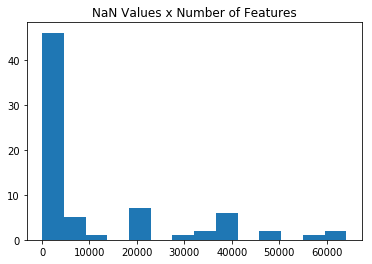

In [12]:
plt.title("NaN Values x Number of Features")
plt.hist(vals, bins = 14)

In [13]:
from sklearn.preprocessing import Imputer

fill_missing = Imputer(missing_values=np.nan, strategy='most_frequent', axis=0)

In [14]:
df_impute = pd.DataFrame(fill_missing.fit_transform(df))

In [15]:
df_impute.columns = df.columns
df_impute.index = df.index

In [16]:
df_impute.count

<bound method DataFrame.count of         ALTERSKATEGORIE_GROB  ANREDE_KZ  FINANZ_MINIMALIST  FINANZ_SPARER  \
1                        1.0        2.0                1.0            5.0   
2                        3.0        2.0                1.0            4.0   
3                        4.0        2.0                4.0            2.0   
4                        3.0        1.0                4.0            3.0   
5                        1.0        2.0                3.0            1.0   
6                        2.0        2.0                1.0            5.0   
7                        1.0        1.0                3.0            3.0   
8                        3.0        1.0                4.0            4.0   
9                        3.0        2.0                2.0            4.0   
10                       3.0        2.0                2.0            2.0   
12                       3.0        1.0                5.0            3.0   
13                       1.0        2.0    

In [17]:
## now check for nans again (after impute)
nan_vals = len(df_impute) - df_impute.count()


In [18]:
nan_vals_sorted = nan_vals.sort_values(ascending=False)
vals = nan_vals_sorted.values

(array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,  73.,   0.,   0.,   0.,
          0.,   0.,   0.]),
 array([-0.5       , -0.42857143, -0.35714286, -0.28571429, -0.21428571,
        -0.14285714, -0.07142857,  0.        ,  0.07142857,  0.14285714,
         0.21428571,  0.28571429,  0.35714286,  0.42857143,  0.5       ]),
 <a list of 14 Patch objects>)

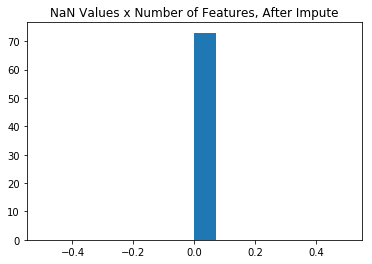

In [24]:
plt.title("NaN Values x Number of Features, After Impute")
plt.hist(vals, bins = 14)

In [25]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.

from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
df_ss = pd.DataFrame(ss.fit_transform(df_impute))
df_ss.columns = df_impute.columns
df_ss.index = df_impute.index

In [26]:
df_ss.columns

Index(['ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'FINANZ_MINIMALIST',
       'FINANZ_SPARER', 'FINANZ_VORSORGER', 'FINANZ_ANLEGER',
       'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER', 'GREEN_AVANTGARDE',
       'HEALTH_TYP', 'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB',
       'RETOURTYP_BK_S', 'SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_REL', 'SEMIO_MAT',
       'SEMIO_VERT', 'SEMIO_LUST', 'SEMIO_ERL', 'SEMIO_KULT', 'SEMIO_RAT',
       'SEMIO_KRIT', 'SEMIO_DOM', 'SEMIO_KAEM', 'SEMIO_PFLICHT', 'SEMIO_TRADV',
       'SOHO_KZ', 'VERS_TYP', 'ANZ_PERSONEN', 'ANZ_TITEL',
       'HH_EINKOMMEN_SCORE', 'W_KEIT_KIND_HH', 'WOHNDAUER_2008',
       'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'KONSUMNAEHE',
       'MIN_GEBAEUDEJAHR', 'WOHNLAGE', 'KBA05_ANTG1', 'KBA05_ANTG2',
       'KBA05_ANTG3', 'KBA05_ANTG4', 'KBA05_GBZ', 'BALLRAUM', 'EWDICHTE',
       'INNENSTADT', 'GEBAEUDETYP_RASTER', 'KKK', 'MOBI_REGIO',
       'ONLINE_AFFINITAET', 'REGIOTYP', 'KBA13_ANZAHL_PKW', 'PLZ8_ANTG1',
       'PLZ8_ANTG2', 'PLZ8_ANTG3', '

In [27]:
def show_distribution(feature, dset1):    
    fig, ax1 = plt.subplots(1, figsize=(12, 4))

    graph_title = f"Feature {feature}"
    fig.suptitle(graph_title, fontsize=16, verticalalignment='baseline')
    sns.countplot(x=feature, data=dset1, ax=ax1)

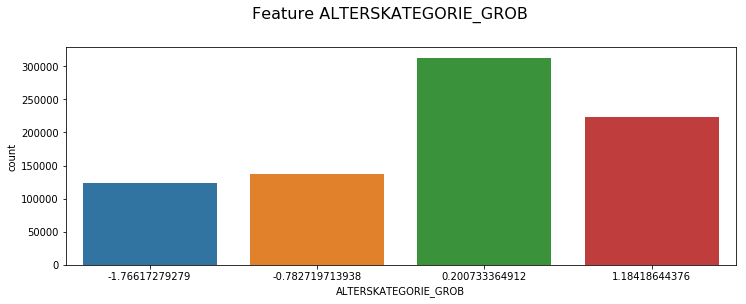

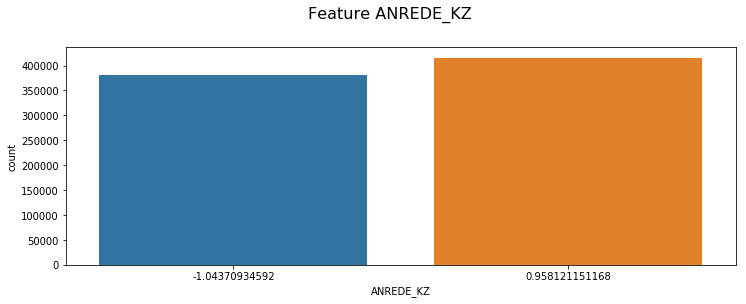

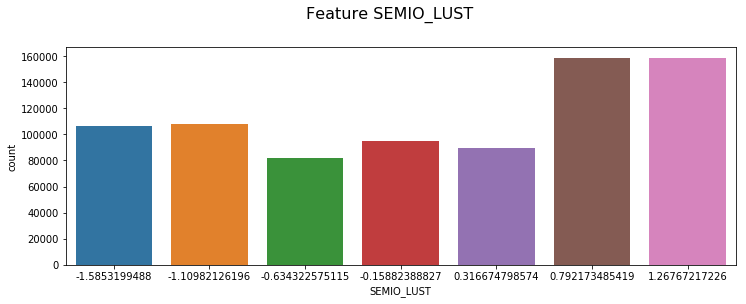

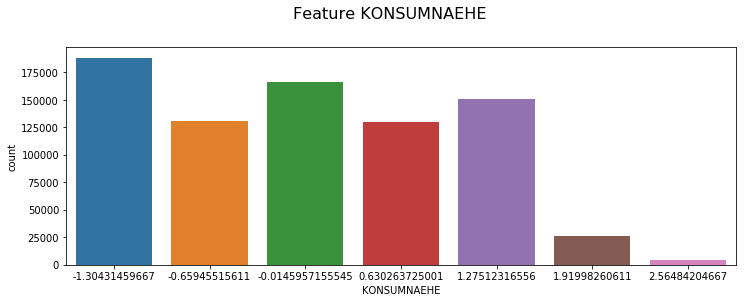

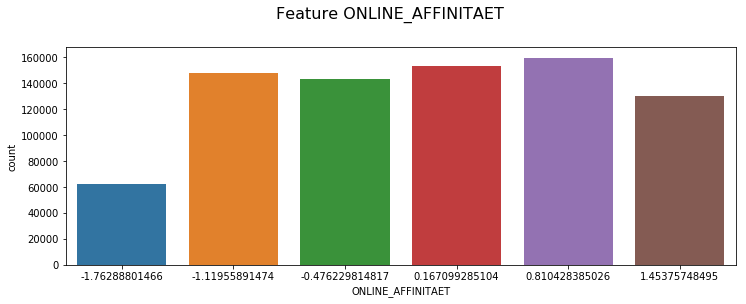

In [28]:
rand_features = ['ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'SEMIO_LUST', 'KONSUMNAEHE', 'ONLINE_AFFINITAET']
for f in rand_features:
    show_distribution(f, df_ss)

In [100]:
# Apply feature scaling to the general population demographics data.



### Discussion 2.1: Apply Feature Scaling

(Double-click this cell and replace this text with your own text, reporting your decisions regarding feature scaling.)

ML algorithms perform better when the data is scaled to a standard range. Data that is not scaled can
throw the algorithms off, as points will not be spaced apart in a comparable way, and wildly different conclusions
may be drawn. For example, if one feature consists of human subject height data measured in inches, whereas another
measures income in 10s of thousands of dollars, then the range of values in the second column may
disproportinately influence the outcome, in a very incorrect way.

In looking through the data dictionary, it appears that most of the data is categorical in nature, rather
than ranges with different scales. Therefore, there is less of a need to normalize, as MinMaxScaler would help
with, and instead StandardScaler may be applied to center the input data points around 0 with standard deviation
of 1.

Spot-checking some of the
features after imputation shows fairly good distribution, although not a bell curve. 
StandardScaler does require data that is well-distributed: it
utilizes the mean (new_value = (value - mean)/std_deviation), so samples that are poorly distributed, e.g. that
include a lot of outliers, may be standardized, but the resulting standardization in such a case
will be influenced by the outliers, because the mean value is influenced by all input values. In this
case, the most extreme outliers have been removed from the dataset before standardization.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [29]:
from sklearn.decomposition import PCA

In [30]:
def do_pca(n_components, data):
    '''
    Transforms data using PCA to create n_components, and provides back the results of the
    transformation.
    
    INPUT: n_components - int - the number of principal components to create
           data - the data you would like to transform
           
    OUTPUT: pca - the pca object created after fitting the data
            X_pca - the transformed X matrix with new number of components
    '''
    X = StandardScaler().fit_transform(data)  ## already did this
    pca = PCA(n_components)
    X_pca = pca.fit_transform(X)
    return pca, X_pca

In [31]:
# Apply PCA to the data.

pca, X_pca = do_pca(73, df_ss)


In [32]:
pca.explained_variance_ratio_

array([  1.59745423e-01,   1.19450784e-01,   8.34985042e-02,
         5.18847800e-02,   4.13008691e-02,   3.19662424e-02,
         3.00603019e-02,   2.77037505e-02,   2.56234223e-02,
         2.25779964e-02,   2.24038105e-02,   2.10401422e-02,
         1.79059558e-02,   1.72193858e-02,   1.66406663e-02,
         1.53937997e-02,   1.51048325e-02,   1.42733108e-02,
         1.36967608e-02,   1.32419433e-02,   1.22643316e-02,
         1.17178816e-02,   1.11340955e-02,   1.07839927e-02,
         1.03270475e-02,   9.94777224e-03,   9.76412509e-03,
         8.79144170e-03,   8.42119783e-03,   7.23044621e-03,
         6.95509151e-03,   6.78185354e-03,   6.54758274e-03,
         6.19989361e-03,   6.00900033e-03,   5.69770439e-03,
         5.47900929e-03,   5.34392419e-03,   5.18720149e-03,
         5.03754160e-03,   4.72142393e-03,   4.16524070e-03,
         4.05714896e-03,   3.96789020e-03,   3.79827331e-03,
         3.60446391e-03,   3.52268320e-03,   3.45020944e-03,
         3.32921537e-03,

In [33]:
def plot_explained_variance(pca):
    plt.figure(figsize=(9,6))
    plt.grid(b=True, which='major', color='#cfcfcf', linestyle='-')    
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.xlabel('number of components')
    plt.ylabel('cumulative explained variance')
    plt.show()

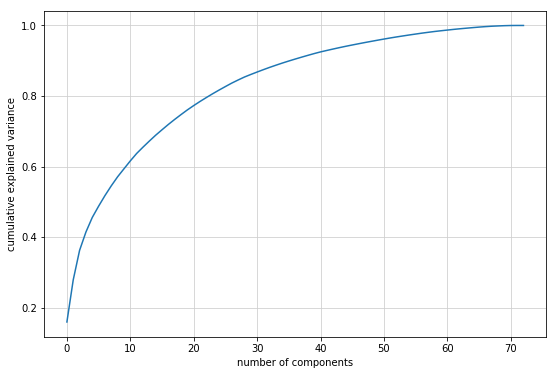

In [34]:
plot_explained_variance(pca)

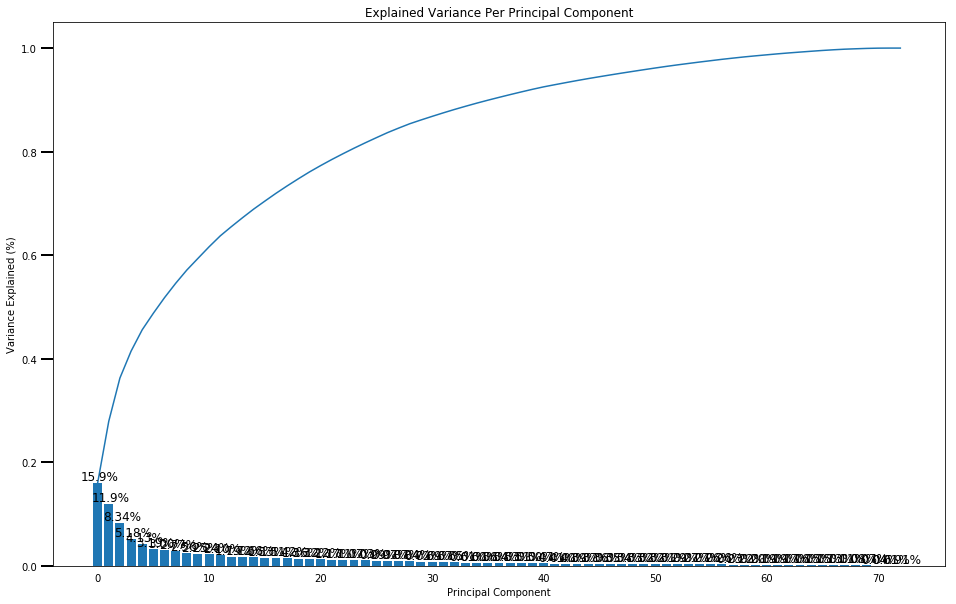

In [35]:
# Investigate the variance accounted for by each principal component.
def scree_plot(pca):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    num_components = len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(16, 10))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    for i in range(num_components):
        ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=12)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')
    


scree_plot(pca)

In [36]:
# Re-apply PCA to the data while selecting for number of components to retain.

# picking 35 (90% -- to avoid overfitting)
n_components = 35
pca, X_pca = do_pca(n_components, df_ss)

In [37]:
pca.components_.shape

(35, 73)

In [50]:
pca.

PCA(copy=True, iterated_power='auto', n_components=35, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

### Discussion 2.2: Perform Dimensionality Reduction

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding dimensionality reduction. How many principal components / transformed features are you retaining for the next step of the analysis?)

PCA will return at most the number of original features (73). When PCA is run for 73 components
and the results plotted, we can see that 100% of the variance is explained when 65 components
are used but 90% of the variance is explained by using the first 35 components. 



### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [38]:
def get_component_important_weights(pca, i):
    if i > len(pca.components_):
        return "no info"
    
    weight_df = pd.DataFrame({'weight': pca.components_[i]}, index=df_ss.columns)
    head_df = weight_df.sort_values(by=['weight']).head(5)
    tail_df = weight_df.sort_values(by=['weight']).tail(5)
    wdf_head_tail = pd.concat([head_df, tail_df], axis=0, sort=True)
    return wdf_head_tail

In [39]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

wdf = get_component_important_weights(pca, 0)

In [40]:
wdf

,weight
PLZ8_ANTG1,-0.222095
MOBI_REGIO,-0.216420
KBA05_GBZ,-0.208471
KBA05_ANTG1,-0.205905
FINANZ_MINIMALIST,-0.204390
ORTSGR_KLS9,0.195125
cameo_econ_stage,0.197383
PLZ8_BAUMAX,0.212152
PLZ8_ANTG4,0.215085
PLZ8_ANTG3,0.221517


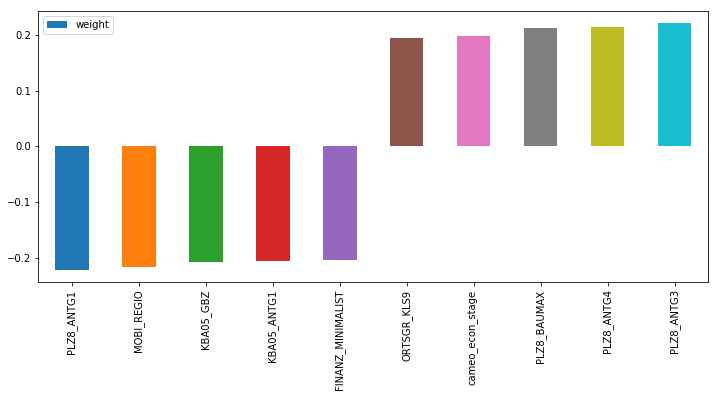

In [41]:
ax = wdf.plot.bar(y='weight', rot=90, figsize=(12,5))

Analysis of weights in first PCA component: These features are connected to the types of homes found in a an area (1-2 person/10+ family), financial interest and success ratings, how mobile (MOBI_REGI). When the features with negative weight values decrease, the strength or influence of this component increases. When the features with positive weight values increase, this PCA component's weight also increases. But the range in weight values for this component are not particulatly high, at -.2 to + .2. This correlates with the fact that this PCA component by itself accounts for just 15.9% of the total variance.

In [42]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.

wdf1 = get_component_important_weights(pca, 1)

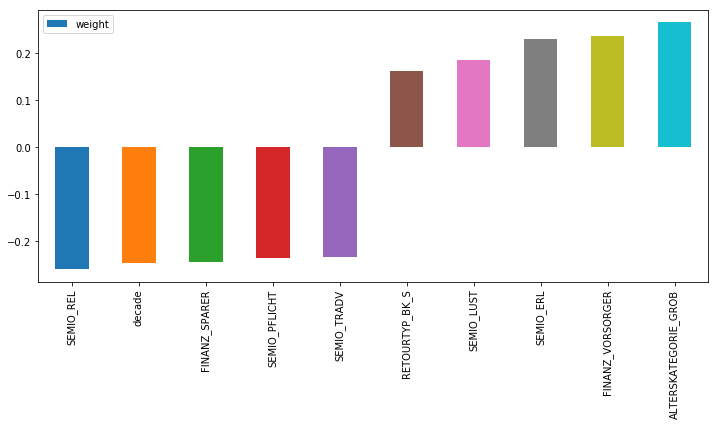

In [43]:
ax = wdf1.plot.bar(y='weight', rot=90, figsize=(12,5))

Analysis of second PCA component: These features that comprise the second PCA component are related to personality as influenced by upbringing -- relgious, dominating movement of a person's youth, whether the person tends towards money-saving, dutiful, traditional-minded -- are all features inversely related to the component. As they decrease, the component increases, and these features tend to be linked, in that they will increase and decrease together. The features for likelihood of returning merchandise, being likely to be financially prepared, being event-oriented, etc -- are positively correlated with the PCA component: as they increase so does the influence of the component.  These positively weighted features tend to increase and decrease together and in opposition to those that are negatively weighted.

There is slightly more variability in the positively weighted features in this component compared to the first PCA component. 

In [44]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

wdf2 = get_component_important_weights(pca, 2)

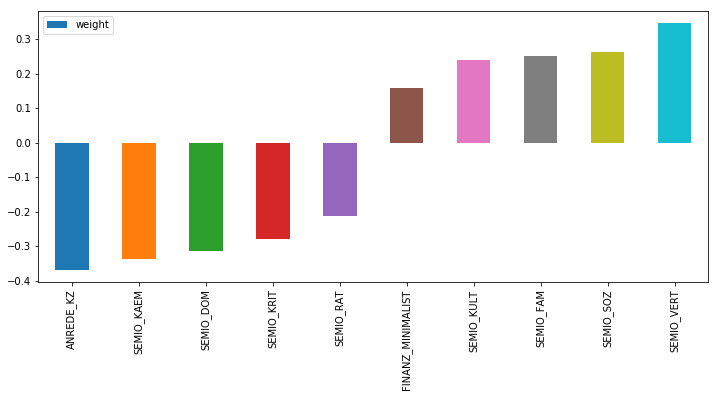

In [45]:
ax = wdf2.plot.bar(y='weight', rot=90, figsize=(12,5))

Analysis of third PCA component: In this component, we have features for male/female, combative attitude, dominant-minded, critical-minded and rational as negative weights, with male/female and combative attitude being relatively strong influencers. Positively weighted features include low financial interest, cultural-mindedness, family-minded, socially-minded, and dreamful. Four of the five positive weights are features that measure personality typology. These features correlate with one another, suggesting that those with one of these traits will likely share the other positively-weighted traits. 

In [46]:
wdf10 = get_component_important_weights(pca, 10)

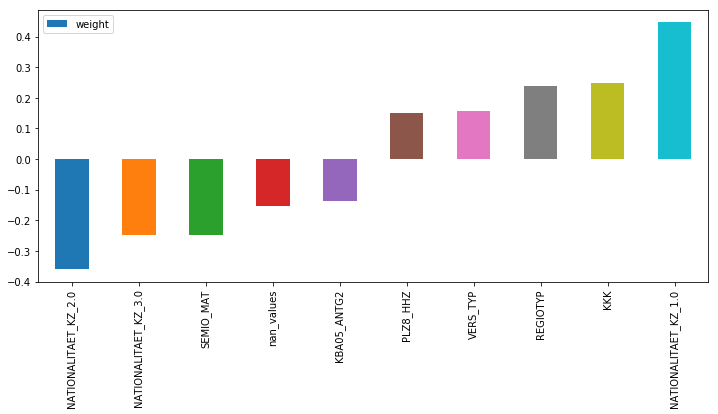

In [47]:
ax = wdf10.plot.bar(y='weight', rot=90, figsize=(12,5))

In [48]:
wdf30 = get_component_important_weights(pca, 30)

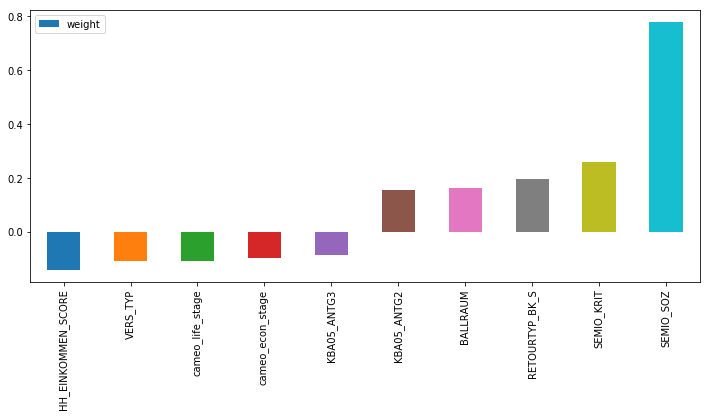

In [49]:
ax = wdf30.plot.bar(y='weight', rot=90, figsize=(12,5))

### Discussion 2.3: Interpret Principal Components

(Double-click this cell and replace this text with your own text, reporting your observations from detailed investigation of the first few principal components generated. Can we interpret positive and negative values from them in a meaningful way?)

The features linked together by each PCA component are categorically similar. The first component
contains features relating to sizes of dwellings (number of families in a house) building types,
sizes of community, and financial interest. The second component links together personality types
influenced by upbringing. The third links together traits such as being combative, a strong
influencer, as well as traits like cultural- and family-mindedness. It makes sense that these
similar traits be linked together -- that they trend upward and downward together -- and it makes
sense that they be collapsed together into fewer dimensions that perhaps can't be named easily by a single
adjective but nonetheless encompass a trait, a latent hidden trait or factor that can used as a
predictor of other traits.


## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [59]:
X_pca


array([[ 3.18104661, -2.89092961, -2.89322317, ...,  0.59401664,
        -0.2856152 , -0.43269184],
       [-0.68921088,  0.47139894, -3.08181242, ..., -1.14729243,
         0.61132418,  0.39655834],
       [-3.59716954,  1.60203801, -0.76410691, ..., -0.48692724,
        -0.36949258, -0.51408378],
       ..., 
       [-1.13728264, -3.19764171, -2.86547628, ..., -0.521411  ,
         0.19079192, -1.59928579],
       [ 5.33759896, -3.54514258,  2.47577271, ..., -0.78979387,
        -0.60163229,  0.75749292],
       [-0.68879346,  1.19340907,  3.04928914, ..., -0.01335417,
        -0.69993417, -0.29467343]])

In [68]:
def plot_data(data, labels):
    '''
    Plot data with colors associated with labels
    '''
    fig = plt.figure();
    ax = Axes3D(fig)
    ax.scatter(data[:, 0], data[:, 1], data[:, 2], c=labels, cmap='tab10');



def get_kmeans_score(data, center):
    '''
    returns the kmeans score regarding SSE for points to centers
    INPUT:
        data - the dataset you want to fit kmeans to
        center - the number of centers you want (the k value)
    OUTPUT:
        score - the SSE score for the kmeans model fit to the data
    '''
    #instantiate kmeans
    kmeans = KMeans(n_clusters=center)

    # Then fit the model to your data using the fit method
    model = kmeans.fit(data)

    # Obtain a score related to the model fit
    score = np.abs(model.score(data))

    return score


In [69]:
get_kmeans_score(X_pca, 3)

41790587.05323419

In [62]:
from sklearn.cluster import KMeans

kmeans_pca = KMeans(10)

model = kmeans_pca.fit(X_pca)
# Over a number of different cluster counts...

labels = model.predict(X_pca)
    # run k-means clustering on the data and...
    
    
    # compute the average within-cluster distances.
    
    

In [65]:
score = np.abs(model.score(X_pca))
print(score)

33417142.982


In [63]:
labels

array([0, 1, 1, ..., 8, 2, 9], dtype=int32)

In [ ]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.



In [ ]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.



### Discussion 3.1: Apply Clustering to General Population

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding clustering. Into how many clusters have you decided to segment the population?)

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [ ]:
# Load in the customer demographics data.
customers = 

In [ ]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.



### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [ ]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.



In [ ]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?



In [ ]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?



### Discussion 3.3: Compare Customer Data to Demographics Data

(Double-click this cell and replace this text with your own text, reporting findings and conclusions from the clustering analysis. Can we describe segments of the population that are relatively popular with the mail-order company, or relatively unpopular with the company?)

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.